In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.cm import get_cmap
from scipy.stats import truncnorm, qmc
from tqdm import tqdm
import sbibm
from sbibm.tasks.gaussian_linear.task import GaussianLinear
import scipy.stats as stats
from scipy.stats import wasserstein_distance, ks_2samp
import seaborn as sns
from itertools import product
import random
import os
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import hamming_loss
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.stats import uniform
from matplotlib import colormaps
import matplotlib.colors as mcolors
import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior
from torch.distributions import Distribution, Uniform, HalfNormal
from torch.distributions.utils import broadcast_all
import math
from ili.utils.distributions_pt import CustomIndependent
import itertools
import pickle
# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

sns.set(style="whitegrid", context="paper", font_scale=1.2)


In [ ]:
with open('/home/x-ctirapongpra/scratch/toy-2-dim-models/uniform/posterior.pkl', 'rb') as f:
    posterior_ensemble_old = pickle.load(f)
with open('/home/x-ctirapongpra/scratch/toy-2-dim-models/taileduniform/posterior.pkl', 'rb') as f:
    posterior_ensemble = pickle.load(f)

In [ ]:
class TailedNormal(Distribution):
    arg_constraints = {
        'a': torch.distributions.constraints.real,
        'b': torch.distributions.constraints.dependent,
        'sigma': torch.distributions.constraints.positive,
    }
    support = torch.distributions.constraints.real
    has_rsample = False

    def __init__(self, a, b, sigma, validate_args=None):
        self.a, self.b, self.sigma = broadcast_all(a, b, sigma)
        if torch.any(self.a >= self.b):
            raise ValueError("`a` must be less than `b`.")
        
        self.Z = math.sqrt(2 * math.pi) * self.sigma + (self.b - self.a)
        self.A = math.sqrt(2 * math.pi) * self.sigma / self.Z
        self.B = (self.b - self.a) / self.Z

        self.halfnormal = HalfNormal(self.sigma)

        super().__init__(batch_shape=self.a.size(), validate_args=validate_args)

    def log_prob(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)

        logA = torch.log(self.A.to(dtype=x.dtype, device=x.device))
        logB = torch.log(self.B.to(dtype=x.dtype, device=x.device))
        log_uniform = logB - torch.log(b - a)

        # left: x <= a => z = a - x
        z_left = torch.abs(a - x)
        log_halfnorm_left = self.halfnormal.log_prob(z_left) + logA - math.log(2.0)

        # right: x >= b => z = x - b
        z_right = torch.abs(x - b)
        log_halfnorm_right = self.halfnormal.log_prob(z_right) + logA - math.log(2.0)

        return torch.where(x <= a, log_halfnorm_left,
               torch.where(x >= b, log_halfnorm_right,
               log_uniform))

    def cdf(self, x):
        x, a, b, sigma = broadcast_all(x, self.a, self.b, self.sigma)
        sqrt2 = math.sqrt(2.0)

        def Phi(z):  # Standard Normal CDF
            return 0.5 * (1 + torch.erf(z / sqrt2))

        left_cdf = self.A * Phi((x - a) / sigma)
        center_cdf = 0.5 * self.A + self.B * (x - a) / (b - a)
        right_cdf = self.B + self.A * Phi((x - b) / sigma)

        return torch.where(x <= a, left_cdf,
               torch.where(x >= b, right_cdf,
               center_cdf))
    
    def icdf(self, u):
        # Helper function for the Inverse Standard Normal CDF
        def inv_Phi(p):
            # Clamping p to avoid NaNs from erfinv at the boundaries 0 and 1
            p_clamped = torch.clamp(p, 1e-9, 1.0 - 1e-9)
            return math.sqrt(2.0) * torch.erfinv(2.0 * p_clamped - 1.0)

        # Thresholds dividing the distribution regions
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        u_left_norm = u / self.A
        left_tail = self.a + self.sigma * inv_Phi(u_left_norm)

        u_right_norm = (u - self.B) / self.A
        right_tail = self.b + self.sigma * inv_Phi(u_right_norm)

        u_middle_norm = (u - thresh_left) / self.B
        middle = self.a + u_middle_norm * (self.b - self.a)

        return torch.where(u < thresh_left, left_tail,
                           torch.where(u > thresh_right, right_tail, middle))
        

    def sample(self, sample_shape=torch.Size()):
        u = torch.rand(sample_shape + self.a.shape, device=self.a.device)
        thresh_left = 0.5 * self.A
        thresh_right = 1.0 - 0.5 * self.A

        left_tail = self.a - self.halfnormal.sample(sample_shape)
        right_tail = self.b + self.halfnormal.sample(sample_shape)

        x_middle = self.a + (u - thresh_left) * (self.b - self.a) / self.B

        return torch.where(u < thresh_left, left_tail,
               torch.where(u > thresh_right, right_tail,
               x_middle))
    
    def sample_lhs(self, n_samples):
        """Sample using Latin Hypercube Sampling"""
        # Generate LHS samples in [0,1]^d
        sampler = qmc.LatinHypercube(d=len(self.a.flatten()), seed=42)
        u_samples = sampler.random(n_samples)
        u_tensor = torch.tensor(u_samples, dtype=torch.float32, device=self.a.device)
        
        # Transform using inverse CDF
        return self.icdf(u_tensor)

    def mean(self):
        return 0.5 * (self.a + self.b)

IndependentTailedNormal = type('IndependentTailedNormal', (CustomIndependent,), {'Distribution': TailedNormal})

In [ ]:
def sample_uniform_lhs(n_samples, dim, low=-1.0, high=1.0, device='cpu'):
    """Generate uniform samples using Latin Hypercube Sampling"""
    sampler = qmc.LatinHypercube(d=dim, seed=42)
    u_samples = sampler.random(n_samples)
    # Transform from [0,1]^d to [low,high]^d
    samples = low + (high - low) * u_samples
    return torch.tensor(samples, dtype=torch.float32, device=device)

In [ ]:
class SBIEvaluator:
   def __init__(self, param_names=['θ₁', 'θ₂']):
       self.param_names = param_names
   
   def c2st(self, X1, X2):
       """C2ST score - lower is better (0.5 = identical distributions)"""
       X = np.vstack([X1, X2])
       y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
       clf = LogisticRegression(max_iter=1000)
       y_pred = clf.fit(X_train, y_train).predict(X_test)
       return hamming_loss(y_test, y_pred)
   
   def tarp_score(self, samples, true_theta):
       """TARP calibration score - lower is better"""
       alpha_levels = np.linspace(0.05, 0.95, 19)
       empirical_coverage = []
       
       for alpha in alpha_levels:
           coverage = all(
               np.percentile(samples[:, j], 100*alpha/2) <= true_theta[j] <= 
               np.percentile(samples[:, j], 100*(1-alpha/2))
               for j in range(len(true_theta))
           )
           empirical_coverage.append(coverage)
       
       expected_coverage = 1 - alpha_levels
       return np.mean(np.abs(expected_coverage - empirical_coverage))
   
   def compare(self, samples_dict, true_theta):
       """Compare multiple methods"""
       results = {}
       methods = list(samples_dict.keys())
       
       for method, samples in samples_dict.items():
           results[method] = {
               'tarp': self.tarp_score(samples, true_theta),
               'mean': np.mean(samples, axis=0),
               'std': np.std(samples, axis=0),
               'c2st_vs_others': {}
           }
       
       # C2ST comparisons
       for i, method1 in enumerate(methods):
           for method2 in methods[i+1:]:
               score = self.c2st(samples_dict[method1], samples_dict[method2])
               results[method1]['c2st_vs_others'][method2] = score
               results[method2]['c2st_vs_others'][method1] = score
       
       return results
   
   def print_results(self, results, true_theta):
       """Print concise comparison"""
       methods = list(results.keys())
       
       print("Method Comparison")
       print("-" * 50)
       
       for method in methods:
           stats = results[method]
           print(f"\n{method}:")
           print(f"  TARP: {stats['tarp']:.4f}")
           for i, param in enumerate(self.param_names):
               print(f"  {param}: Mean={stats['mean'][i]:.3f}, Std={stats['std'][i]:.3f}")
           
           if stats['c2st_vs_others']:
               c2st_str = ", ".join([f"{k}={v:.3f}" for k, v in stats['c2st_vs_others'].items()])
               print(f"  C2ST: {c2st_str}")

In [ ]:
class GridEvaluator:
    def __init__(self, simulator, param_ranges, task):
        self.simulator = simulator
        self.param_ranges = param_ranges
        self.task = task

    def create_test_points(self, n_points_per_dim):
        """Create test points on rectangular grid"""
        x_points = np.linspace(self.param_ranges[0][0], self.param_ranges[0][1], n_points_per_dim)
        y_points = np.linspace(self.param_ranges[1][0], self.param_ranges[1][1], n_points_per_dim)
        
        test_points = []
        for x in x_points:
            for y in y_points:
                test_points.append([x, y])
        
        return np.array(test_points)

    def evaluate_all(self, posterior_dict, test_points, n_samples=n_posterior_samples):
        """Evaluate all posteriors including reference"""
        observations = []
        results = {'test_points': test_points}

        for theta in tqdm(test_points):
            x_obs = self.simulator(torch.tensor(theta, dtype=torch.float32))
            observations.append(x_obs)

        results['observations'] = observations

        ref_samples = []
        for x_obs in tqdm(observations, desc="Reference"):
            ref_post = self.task._get_reference_posterior(observation=x_obs.unsqueeze(0))
            ref_samples.append(ref_post.sample((n_samples,)).cpu().numpy())
        results['Reference'] = ref_samples

        for name, posterior in posterior_dict.items():
            samples = []
            for x_obs in tqdm(observations, desc=name):
                samples.append(posterior.sample((n_samples,), x_obs).cpu().numpy())
            results[name] = samples

        return results

    def c2st(self, X1, X2):
        """C2ST score"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss

        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        return hamming_loss(y_test, LogisticRegression(max_iter=1000).fit(X_train, y_train).predict(X_test))

    def compute_c2st_grid(self, results, n_points_per_dim):
        """Compute C2ST for grid points"""
        methods = ['Uniform_NPE', 'TailedNormal_NPE', 'Reference']
        c2st_grid = {}

        for i, m1 in enumerate(methods):
            for m2 in methods[i+1:]:
                comparison_name = f"{m1}_vs_{m2}"
                c2st_values = []
                
                for idx in range(len(results['test_points'])):
                    c2st_val = self.c2st(results[m1][idx], results[m2][idx])
                    c2st_values.append(c2st_val)
                
                c2st_grid[comparison_name] = np.array(c2st_values).reshape(n_points_per_dim, n_points_per_dim)

        return c2st_grid

    def plot_c2st_grid(self, c2st_grid, n_points_per_dim):
        sns.set(style = "white")
        """Plot C2ST scores as heatmaps"""
        comparisons = list(c2st_grid.keys())
        fig, axes = plt.subplots(len(comparisons), 1, figsize=(10, 8*len(comparisons)))
        if len(comparisons) == 1: axes = [axes]

        for i, comp in enumerate(comparisons):
            im = axes[i].imshow(c2st_grid[comp], cmap='RdYlBu_r', vmin=0.3, vmax=0.6, 
                               extent=[self.param_ranges[0][0], self.param_ranges[0][1], 
                                      self.param_ranges[1][0], self.param_ranges[1][1]], 
                               origin='lower')
            
            # Add text annotations
            for j in range(n_points_per_dim):
                for k in range(n_points_per_dim):
                    value = c2st_grid[comp][j, k]
                    color = 'white' if value > 0.5 else 'black'
                    
                    # Calculate pixel coordinates for centering
                    x_extent = self.param_ranges[0][1] - self.param_ranges[0][0]
                    y_extent = self.param_ranges[1][1] - self.param_ranges[1][0]
                    x_pos = self.param_ranges[0][0] + (k + 0.5) * x_extent / n_points_per_dim
                    y_pos = self.param_ranges[1][0] + (j + 0.5) * y_extent / n_points_per_dim
                    
                    axes[i].text(x_pos, y_pos, f'{value:.2f}', ha='center', va='center', 
                               color=color, fontweight='bold', fontsize=6)
            
            axes[i].set_title(comp.replace('_', ' '), fontsize=16)
            axes[i].set_xlabel('Parameter 1', fontsize=14)
            axes[i].set_ylabel('Parameter 2', fontsize=14)
            fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04, label='C2ST Score')

        plt.tight_layout()
        filename = f'toy-2-dim-figures/heatmap.png'
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved plot: {filename}")
        plt.show()


In [ ]:
n_simulations = 4000
n_posterior_samples = 2000

# Parameters ranges
param_1_range = (-1.0, 1.0)
param_2_range = (-1.0, 1.0)
param_ranges = [param_1_range, param_2_range]

param_1_width = param_1_range[1] - param_1_range[0]
param_2_width = param_2_range[1] - param_2_range[0]

# Scale sigma relative to parameter ranges
sigma_scale = 0.1
sigmas = [sigma_scale * (high - low) for low, high in param_ranges]

# Task setup
task = GaussianLinear(
    dim=2, prior_scale=param_1_width/2
)
simulator = task.get_simulator()

In [ ]:
# Training for edge cases
# Define theta_true close to the lower bounds of each parameter

theta_true_edge = np.array([
    param_1_range[1] - 0.1 * param_1_width,
    param_2_range[1] - 0.1 * param_2_width
])

# Print selected parameter values
print(f"  Param 1: [{param_ranges[0][0]}, {param_ranges[0][1]}] -> selected: {theta_true_edge[0]:.3f}")
print(f"  Param 2: [{param_ranges[1][0]}, {param_ranges[1][1]}] -> selected: {theta_true_edge[1]:.3f}")

# Generate observation using the edge case theta_true
x_obs_edge = simulator(torch.Tensor(theta_true_edge))

# Sample from uniform-trained model
samples_uniform = posterior_ensemble_old.sample((n_posterior_samples,), x_obs_edge)
samples_uniform = samples_uniform.cpu().numpy()

# Sample from TailedNormal-trained model  
samples_tailed = posterior_ensemble.sample((n_posterior_samples,), x_obs_edge)
samples_tailed = samples_tailed.cpu().numpy()

# Get reference posterior for the edge case
xobs_edge = x_obs_edge.clone().detach()
ref_edge = task._get_reference_posterior(observation=xobs_edge)
ref_samples_edge = ref_edge.sample((n_posterior_samples,))

  Param 1: [-1.0, 1.0] -> selected: 0.800
  Param 2: [-1.0, 1.0] -> selected: 0.800


Drawing 1336 posterior samples:   0%|          | 0/1336 [00:00<?, ?it/s]

Drawing 586 posterior samples: 100%|██████████| 586/586 [00:00<00:00, 149659.75it/s]


In [ ]:
# Create evaluator and run comparison
evaluator = SBIEvaluator()

samples_dict = {
   'Uniform_NPE': samples_uniform,
   'TailedNormal_NPE': samples_tailed,
   'RefPosterior': ref_samples_edge.numpy()
}

results = evaluator.compare(samples_dict, theta_true_edge)
evaluator.print_results(results, theta_true_edge)

Method Comparison
--------------------------------------------------

Uniform_NPE:
  TARP: 0.3737
  θ₁: Mean=0.266, Std=0.435
  θ₂: Mean=0.611, Std=0.255
  C2ST: TailedNormal_NPE=0.443, RefPosterior=0.447

TailedNormal_NPE:
  TARP: 0.3158
  θ₁: Mean=0.337, Std=0.497
  θ₂: Mean=0.678, Std=0.303
  C2ST: Uniform_NPE=0.443, RefPosterior=0.480

RefPosterior:
  TARP: 0.3737
  θ₁: Mean=0.405, Std=0.300
  θ₂: Mean=0.665, Std=0.300
  C2ST: Uniform_NPE=0.447, TailedNormal_NPE=0.480


Saved plot: toy-2-dim-figures/histogram.png


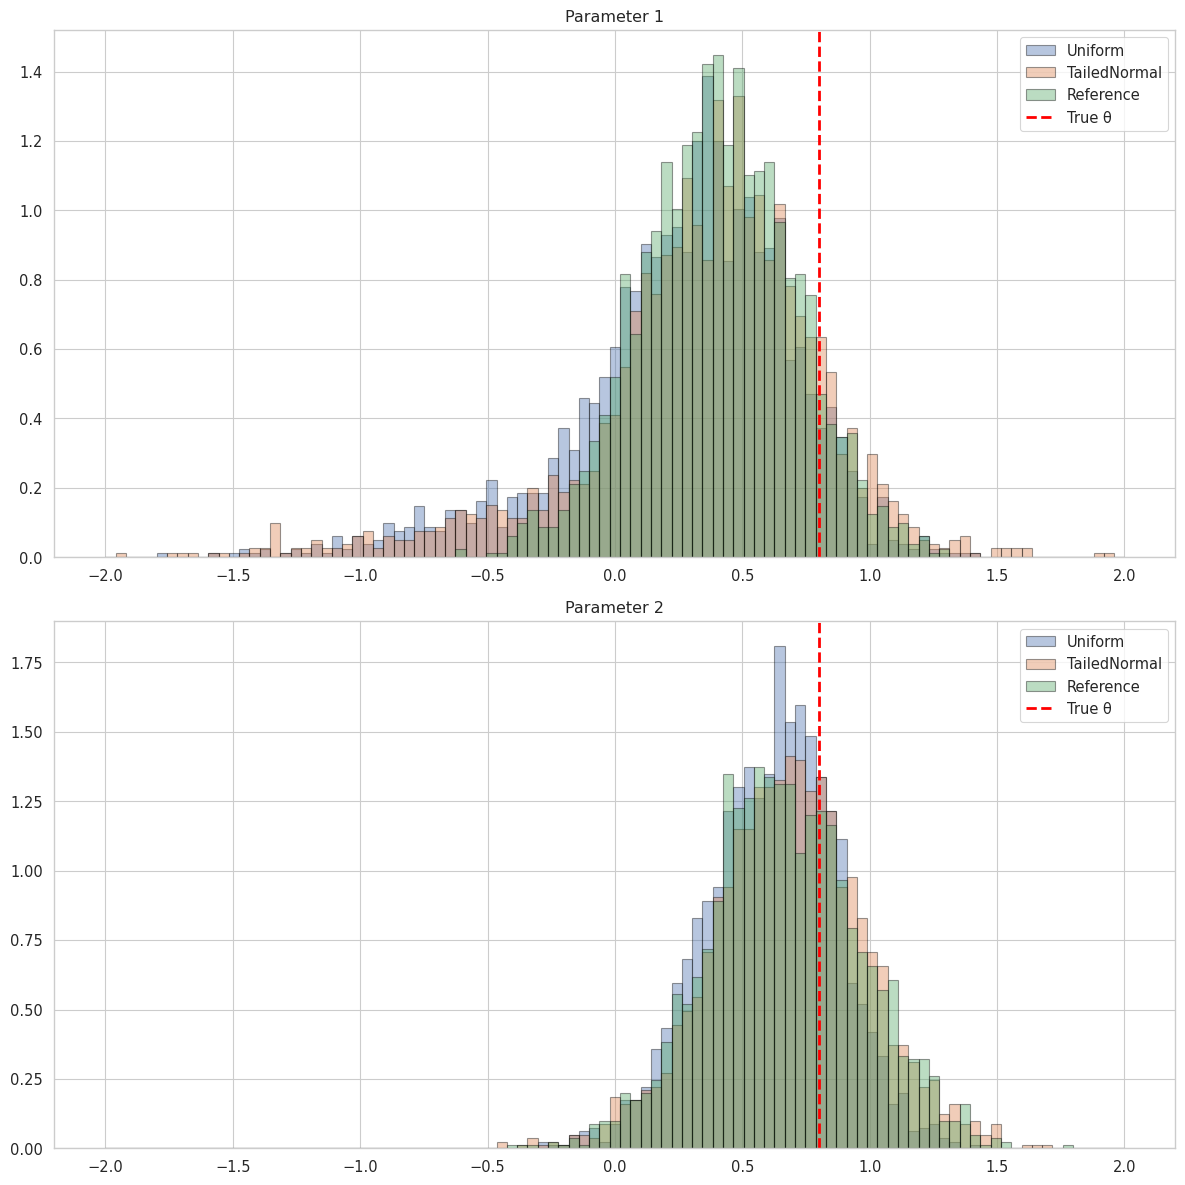

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

methods = ['Uniform', 'TailedNormal', 'Reference']
samples_list = [samples_uniform, samples_tailed, ref_samples_edge.numpy()]

for i, param in enumerate(['Parameter 1', 'Parameter 2']):
   for method, samples in zip(methods, samples_list):
       axes[i].hist(samples[:, i], bins=np.linspace(-2,2,100), alpha=0.4, density=True, label=method, edgecolor='black')
   
   axes[i].axvline(theta_true_edge[i], color='red', linestyle='--', linewidth=2, label='True θ')
   axes[i].set_title(f'{param}')
   axes[i].legend()

plt.tight_layout()
os.makedirs('toy-2-dim-figures', exist_ok=True)
filename = f'toy-2-dim-figures/histogram.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

Saved plot: toy-2-dim-figures/corner.png


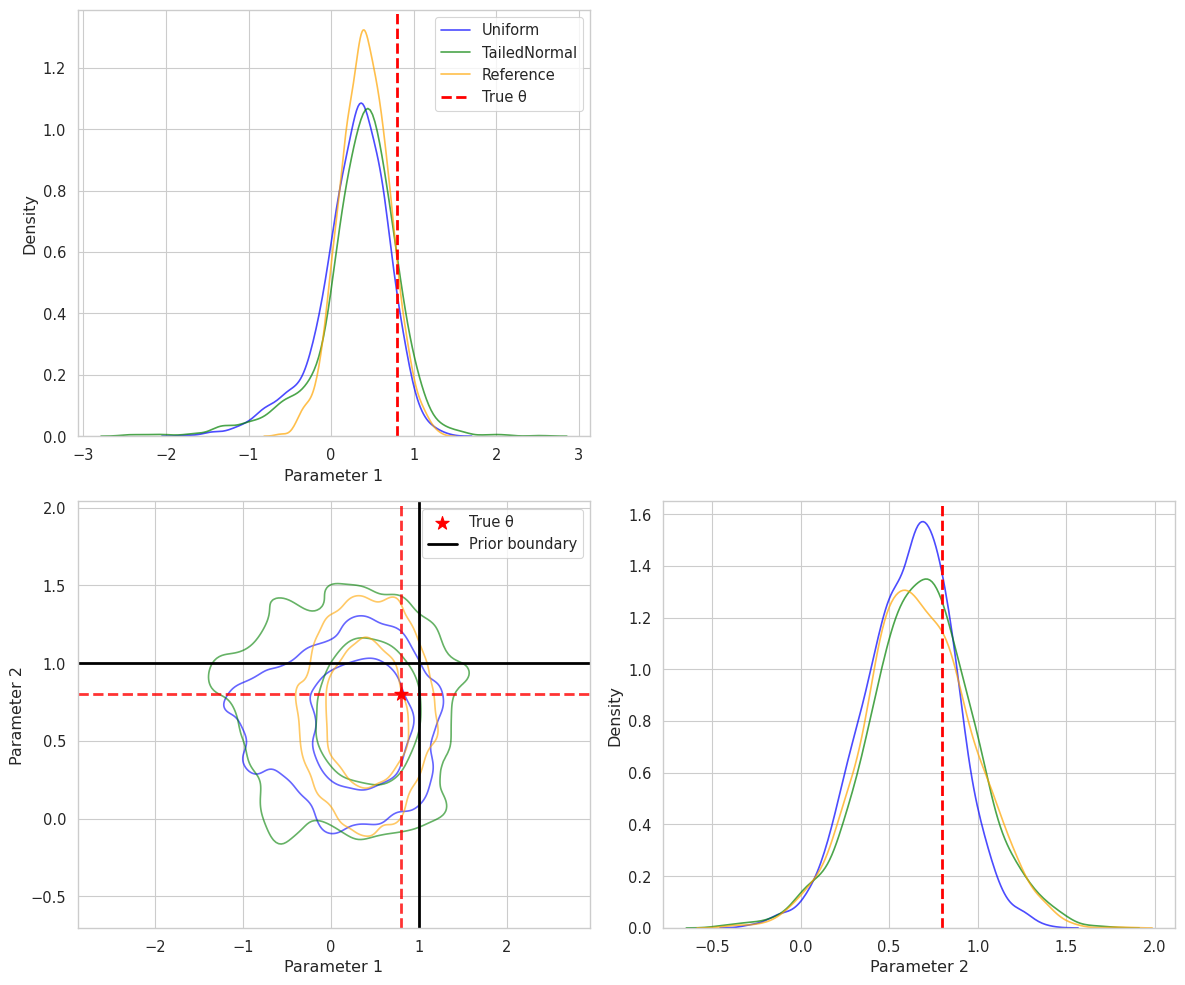

In [ ]:
# Create corner plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

methods = ['Uniform', 'TailedNormal', 'Reference']
samples_list = [samples_uniform, samples_tailed, ref_samples_edge.numpy()]
colors = ['blue', 'green', 'orange']
param_names = ['Parameter 1', 'Parameter 2']

# Plot marginal distributions (diagonal)
for i in range(2):
    ax = axes[i, i]
    for method, samples, color in zip(methods, samples_list, colors):
        sns.kdeplot(data=samples[:, i], ax=ax, label=method, color=color, alpha=0.7)
    
    # Add true parameter line
    ax.axvline(theta_true_edge[i], color='red', linestyle='--', linewidth=2, label='True θ')
    ax.set_xlabel(param_names[i])
    ax.set_ylabel('Density')
    if i == 0:
        ax.legend()

# Plot joint distributions (off-diagonal)
ax = axes[1, 0]  # Bottom-left for joint distribution
for method, samples, color in zip(methods, samples_list, colors):
    sns.kdeplot(x=samples[:, 0], y=samples[:, 1], ax=ax, color=color, alpha=0.6, 
                levels=[0.05, 0.32, 1], label=method, fill=False)

# Add true parameter point
ax.scatter(theta_true_edge[0], theta_true_edge[1], color='red', s=100, 
           marker='*', label='True θ', zorder=10)

# Add red lines to show true parameter values as boundaries
ax.axvline(theta_true_edge[0], color='red', linestyle='--', linewidth=2, alpha=0.8)
ax.axhline(theta_true_edge[1], color='red', linestyle='--', linewidth=2, alpha=0.8)

# Add black boundary at prior edge (x=1 and y=1)
ax.axvline(1.0, color='black', linestyle='-', linewidth=2, alpha=1.0, label='Prior boundary')
ax.axhline(1.0, color='black', linestyle='-', linewidth=2, alpha=1.0)

ax.set_xlabel(param_names[0])
ax.set_ylabel(param_names[1])
ax.legend()

# Remove top-right subplot (not needed in corner plot)
axes[0, 1].remove()

plt.tight_layout()
filename = f'toy-2-dim-figures/corner.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

/tmp/ipykernel_287678/3898867095.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=methods)
/tmp/ipykernel_287678/3898867095.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(data, labels=methods)


Saved plot: toy-2-dim-figures/boxpot.png


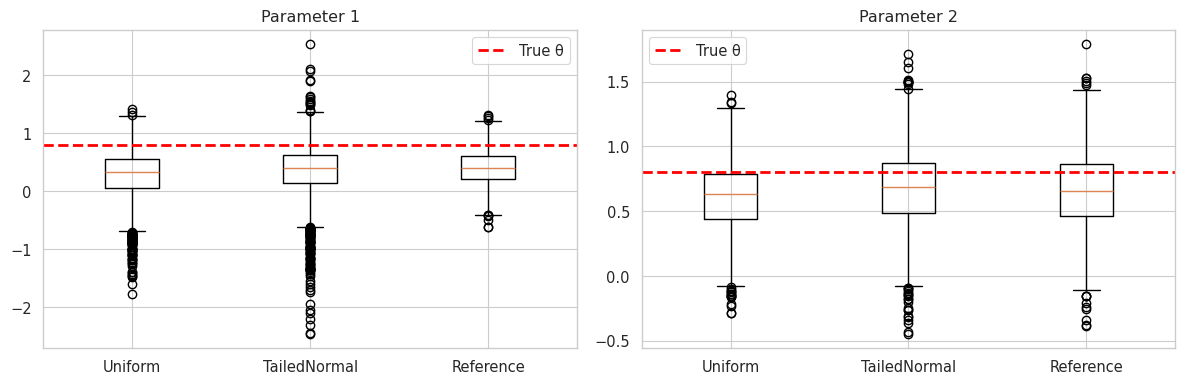

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

methods = ['Uniform', 'TailedNormal', 'Reference']
samples_list = [samples_uniform, samples_tailed, ref_samples_edge.numpy()]

for i, param in enumerate(['Parameter 1', 'Parameter 2']):
   data = [samples[:, i] for samples in samples_list]
   
   axes[i].boxplot(data, labels=methods)
   axes[i].axhline(theta_true_edge[i], color='red', linestyle='--', linewidth=2, label='True θ')
   axes[i].set_title(f'{param}')
   axes[i].legend()

plt.tight_layout()
filename = f'toy-2-dim-figures/boxpot.png'
plt.savefig(filename, bbox_inches='tight')
print(f"Saved plot: {filename}")
plt.show()

In [ ]:
n_points_per_dim = 20
rect_evaluator = GridEvaluator(simulator, param_ranges, task)

posterior_dict = {
    'Uniform_NPE': posterior_ensemble_old,
    'TailedNormal_NPE': posterior_ensemble
}

test_points = rect_evaluator.create_test_points(n_points_per_dim)
results = rect_evaluator.evaluate_all(posterior_dict, test_points)
c2st_grid = rect_evaluator.compute_c2st_grid(results, n_points_per_dim)

TailedNormal_NPE: 100%|██████████| 400/400 [00:12<00:00, 32.49it/s]


Saved plot: toy-2-dim-figures/heatmap.png


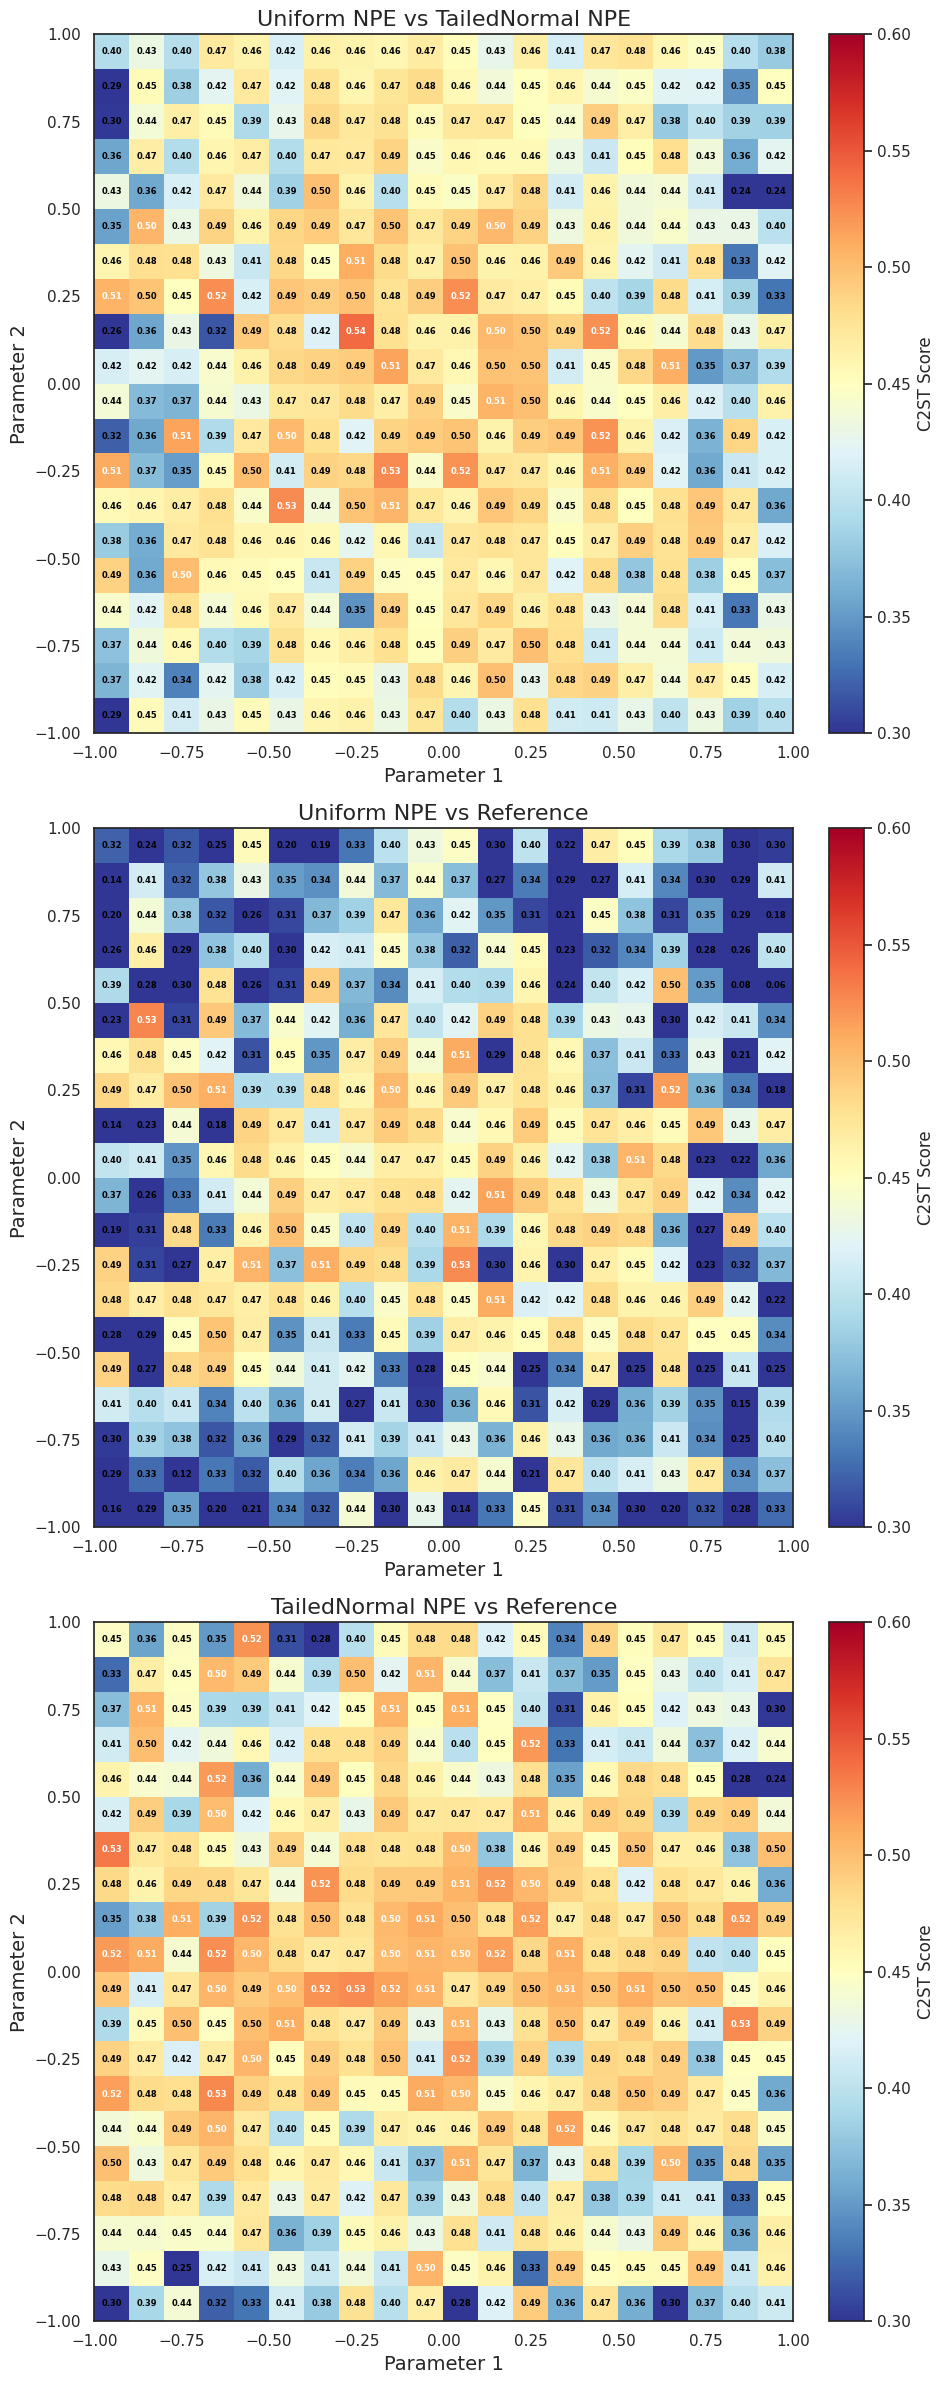

In [ ]:
rect_evaluator.plot_c2st_grid(c2st_grid=c2st_grid, n_points_per_dim=n_points_per_dim)

In [ ]:
class CircleEvaluator:
    def __init__(self, simulator, param_ranges, task):
        self.simulator = simulator
        self.param_ranges = param_ranges
        self.task = task
        self.prior_center = np.array([(low + high) / 2 for low, high in param_ranges])
        self.max_radius = min([(high - low) / 2 for low, high in param_ranges])

    def create_test_points(self, n_radii=20, n_angles=30):
        """Create test points on concentric circles"""
        test_points = [self.prior_center.copy()]
        radii = [0.0]

        for radius in np.linspace(0.2 * self.max_radius, 0.9 * self.max_radius, n_radii):
            for angle in np.linspace(0, 2*np.pi, n_angles, endpoint=False):
                x = self.prior_center[0] + radius * np.cos(angle)
                y = self.prior_center[1] + radius * np.sin(angle)

                if (self.param_ranges[0][0] <= x <= self.param_ranges[0][1] and 
                    self.param_ranges[1][0] <= y <= self.param_ranges[1][1]):
                    test_points.append([x, y])
                    radii.append(radius)

        return np.array(test_points), np.array(radii)

    def evaluate_all(self, posterior_dict, test_points, n_samples=n_posterior_samples):
        """Evaluate all posteriors including reference"""
        observations = []
        results = {'test_points': test_points}

        # Generate observations and reference posteriors
        for theta in tqdm(test_points):
            x_obs = self.simulator(torch.tensor(theta, dtype=torch.float32))
            observations.append(x_obs)

        results['observations'] = observations

        # Reference posteriors
        ref_samples = []
        for x_obs in tqdm(observations, desc="Reference"):
            ref_post = self.task._get_reference_posterior(observation=x_obs.unsqueeze(0))
            ref_samples.append(ref_post.sample((n_samples,)).cpu().numpy())
        results['Reference'] = ref_samples

        # Learned posteriors
        for name, posterior in posterior_dict.items():
            samples = []
            for x_obs in tqdm(observations, desc=name):
                samples.append(posterior.sample((n_samples,), x_obs).cpu().numpy())
            results[name] = samples

        return results

    def c2st(self, X1, X2):
        """C2ST score"""
        from sklearn.model_selection import train_test_split
        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import hamming_loss

        X = np.vstack([X1, X2])
        y = np.concatenate([np.zeros(len(X1)), np.ones(len(X2))])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        return hamming_loss(y_test, LogisticRegression(max_iter=1000).fit(X_train, y_train).predict(X_test))

    def compute_c2st_by_radius(self, results, radii):
        """Compute C2ST organized by radius"""
        methods = ['Uniform_NPE', 'TailedNormal_NPE', 'Reference']
        unique_radii = np.unique(np.round(radii, 3))
        c2st_data = {}

        for radius in unique_radii:
            indices = np.where(np.abs(radii - radius) < 1e-3)[0]
            c2st_data[f'{radius:.3f}'] = {}

            for i, m1 in enumerate(methods):
                for m2 in methods[i+1:]:
                    c2st_vals = [self.c2st(results[m1][idx], results[m2][idx]) for idx in indices]
                    c2st_data[f'{radius:.3f}'][f"{m1}_vs_{m2}"] = c2st_vals

        return c2st_data

    def plot_c2st_by_radius(self, c2st_data):
        """Plot average C2ST scores by radius"""
        comparisons = list(next(iter(c2st_data.values())).keys())
        radii = [float(r) for r in c2st_data.keys()]

        plt.figure(figsize=(10, 6))

        for comp in comparisons:
            avg_c2st = []
            for radius_str in c2st_data.keys():
                vals = c2st_data[radius_str][comp]
                avg_c2st.append(np.mean(vals))

            plt.plot(radii, avg_c2st, 'o-', label=comp)

        plt.axhline(0.5, color='gray', linestyle='--', linewidth=2, label='Ideal C2ST=0.5')
        plt.xlabel('Radius')
        plt.ylabel('Average Error Metric [C2ST]')
        plt.title('C2ST Performance by Distance from Center')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        filename = f'toy-2-dim-figures/c2st-radius.png'
        plt.savefig(filename, bbox_inches='tight')
        print(f"Saved plot: {filename}")
        plt.show()

    def plot_c2st_tables(self, c2st_data):
        """Plot C2ST as colored tables"""
        sns.set(style="white")
        comparisons = list(next(iter(c2st_data.values())).keys())
        fig, axes = plt.subplots(len(comparisons), 1, figsize=(20, 10*len(comparisons)))
        if len(comparisons) == 1: axes = [axes]

        for i, comp in enumerate(comparisons):
            radii = list(c2st_data.keys())
            max_pts = max(len(c2st_data[r][comp]) for r in radii)

            # Create data matrix
            data = np.full((len(radii), max_pts), np.nan)
            for j, r in enumerate(radii):
                vals = c2st_data[r][comp]
                data[j, :len(vals)] = vals

            # Plot
            im = axes[i].imshow(data, cmap='RdYlBu_r', vmin=0.3, vmax=0.6)

            # Add text
            for j in range(len(radii)):
                for k in range(max_pts):
                    if not np.isnan(data[j, k]):
                        color = 'white' if data[j, k] > 0.5 else 'black'
                        axes[i].text(k, j, f'{data[j, k]:.2f}', ha='center', va='center', 
                                     color=color, fontweight='bold')

            axes[i].set_yticks(range(len(radii)))
            axes[i].set_yticklabels([f'r={r}' for r in radii])
            axes[i].set_title(comp.replace('_', ' '))
            plt.colorbar(im, ax=axes[i])

        plt.tight_layout()
        plt.show()

In [ ]:
evaluator = CircleEvaluator(simulator, param_ranges, task)
posterior_dict = {
    'Uniform_NPE': posterior_ensemble_old,
    'TailedNormal_NPE': posterior_ensemble
}

test_points, radii = evaluator.create_test_points()
results = evaluator.evaluate_all(posterior_dict, test_points)
c2st_data = evaluator.compute_c2st_by_radius(results, radii)

TailedNormal_NPE: 100%|██████████| 601/601 [01:09<00:00,  8.65it/s]


Saved plot: toy-2-dim-figures/c2st-radius.png


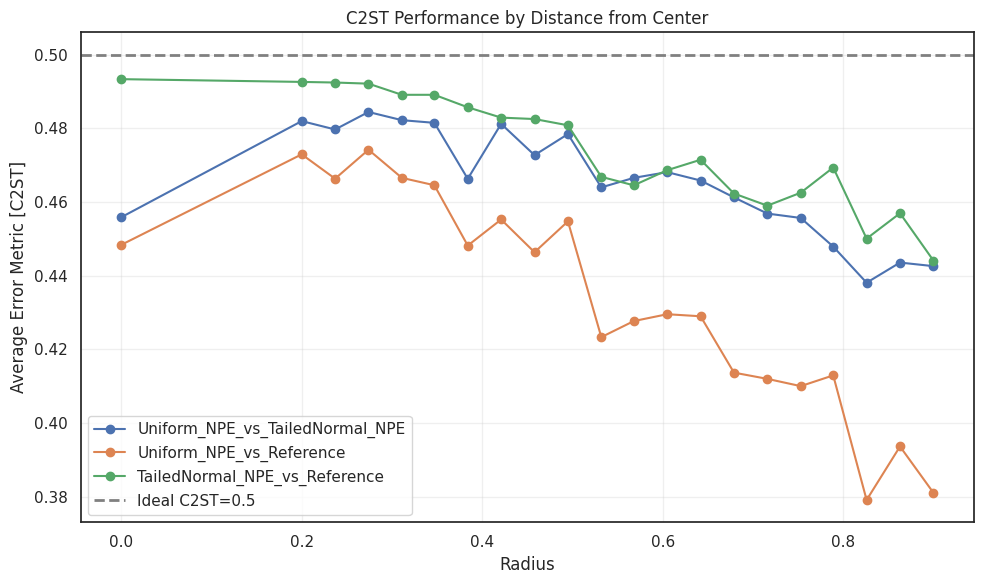

In [ ]:
evaluator.plot_c2st_by_radius(c2st_data)